In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from numpy import genfromtxt
import csv
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import time
import csv
from sklearn.impute import SimpleImputer as Imputer
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Layer
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten 
from tensorflow.keras import backend as K
from numpy.random import seed
seed(1)
import random
random.seed(3)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score

C:\Users\91948\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Read the Secom dataset
reader = csv.reader(open("SECOM/SECOM.TXT"), delimiter=" ")
Data = pd.DataFrame(reader)
labels = csv.reader(open("SECOM/SECOM_labels.TXT"), delimiter=" ")
secom_labels = pd.DataFrame(labels)
y = secom_labels[0].astype('int8')
print("Data size",Data.shape)
print('Labels size',y.shape)
print("Minority class count =", np.sum(y==1))
print(Data.head())
Data.info()
#Data = Data.astype('float')
Target = pd.DataFrame()
Target['tar'] = y

Data size (1567, 590)
Labels size (1567,)
Minority class count = 104
       0        1          2          3       4    5         6       7    \
0  3030.93     2564  2187.7333  1411.1265  1.3602  100   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100   95.4878  0.1241   
3  2988.72   2479.9  2199.0333   909.7926  1.3204  100  104.2367  0.1217   
4  3032.24  2502.87  2233.3667    1326.52  1.5334  100  100.3967  0.1235   

      8        9    ...     580       581     582     583     584      585  \
0  1.5005   0.0162  ...     NaN       NaN  0.5005  0.0118  0.0035    2.363   
1  1.4966  -0.0005  ...   0.006  208.2045  0.5019  0.0223  0.0055   4.4447   
2  1.4436   0.0041  ...  0.0148   82.8602  0.4958  0.0157  0.0039   3.1745   
3  1.4882  -0.0124  ...  0.0044   73.8432   0.499  0.0103  0.0025   2.0544   
4  1.5031  -0.0031  ...     NaN       NaN    0.48  0.4766  0.1045  99.3032   

     

In [3]:
Data.shape

(1567, 590)

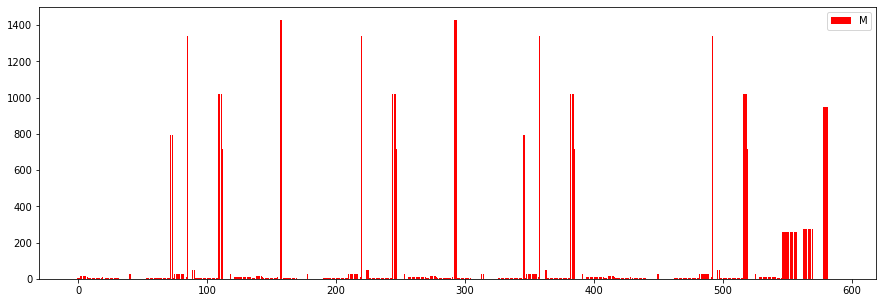

In [4]:
#Handling missing data
missdata_Columns = []
for i in Data.columns:
    if np.sum(Data[i][:] == 'NaN') >0:
        missdata_Columns.append([i,np.sum(Data[i][:] == 'NaN')])
        #print( i, ':',np.sum(Data[i][:] == 'NaN') )
        
missdata_df = pd.DataFrame(missdata_Columns)
plt.figure(figsize=(15,5))
plt.bar(missdata_df[0],missdata_df[1],color='red')
plt.legend('Missing')
#plt.savefig('SecomDatamissing.png')
#plt.show()

In [5]:
#Replace NaN in missing values with -1.0
Data = Data.replace(to_replace = 'NaN', value = '-1.0')
Datafloat = Data.copy()
#Convert to float datatype
Datafloat = Datafloat.astype('float64')

In [6]:
# Impute Missing Values
def impute(df, cols,strat):
    imputer = Imputer(missing_values = -1.0,strategy=strat)
    df_impute = df[cols]
    df[cols] = imputer.fit_transform(df_impute.values.reshape(-1,1))
    return df

In [7]:
#Imputing strategy mean, nearest and linear interpolation
for i in Datafloat.columns:
    if np.abs(np.sum(Datafloat[i][:] == -1.0)) >= 700:
        
        Datafloat.drop([i],inplace = True,axis =1)
    elif np.abs(np.sum(Datafloat[i][:] == -1.0)) <=30:
    #    print(i)
        600 #and np.abs(np.sum(Data[i][:] == -1.0)) <=780:
        Datafloat = impute(Datafloat,i,'mean')
    elif np.abs(np.sum(Datafloat[i][:] == -1.0))  > 30 and np.abs(np.sum(Datafloat[i][:] == -1))  <=200:
        Datafloat[i].replace(to_replace = -1.0, value = None)
        Datafloat[i].interpolate(method ='nearest', limit_direction ='forward')
    elif np.abs(np.sum(Datafloat[i][:] == -1.0))  > 200 and np.abs(np.sum(Datafloat[i][:] == -1))  <=300:
        Datafloat[i].replace(to_replace = -1.0, value = None)
        Datafloat[i].interpolate(method ='linear', limit_direction ='both')

In [8]:
#Get the unique value columns
def uniq_cols_fn(data):
    uniq_col_list = []
    for column in data.columns:
        if data[column].nunique() == 1:
            uniq_col_list.append(column)
    return uniq_col_list

In [9]:
len(uniq_cols_fn(Datafloat))

116

In [10]:
Datafloat = Datafloat.drop(axis=1, columns=uniq_cols_fn(Datafloat))
Datafloat.shape

(1567, 442)

In [11]:
np.sum(y==-1)

1463

In [12]:
#Normalize the data between +1 and -1
mmscaler    = MinMaxScaler(feature_range=(-1,1))
Datascaled   = mmscaler.fit_transform(Datafloat)

In [13]:
TrainDatascaled = Datascaled
y_trn = y

In [14]:
TrainDatascaled.shape

(1567, 442)

In [15]:
def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.sqrt(np.prod(tp_rate))
    return ACSA, GM

## VAE

#### VAE code is adopted and modified from the following reference.
#### https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter8-vae/vae-mlp-mnist-8.1.1.py

In [16]:
start_dimension = Datafloat.shape[1]
input_shape = (Datafloat.shape[1], )
intermediate_dim = 220 
batch_size = 24
latent_dim = 7
epochs = 1000

### Sampling

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Encoder

In [18]:
# Encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])


encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 442)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 220)          97460       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 7)            1547        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 7)            1547        dense[0][0]                      
____________________________________________________________________________________________

### Decoder

In [19]:
# Decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(start_dimension, activation='tanh')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 220)               1760      
_________________________________________________________________
dense_2 (Dense)              (None, 442)               97682     
Total params: 99,442
Trainable params: 99,442
Non-trainable params: 0
_________________________________________________________________


In [20]:
# VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [21]:

X_trainvae, X_valvae, y_trvae, y_valvae = train_test_split(TrainDatascaled, TrainDatascaled, 
                                                    test_size=0.15, random_state=1)

In [22]:
start_time = time.time()

In [23]:
if __name__ == '__main__':
    
    loss = 'mse'
    models = (encoder, decoder)
    
    if loss == 'bce':
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)
        
    reconstruction_loss *= start_dimension
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    vae.fit(X_trainvae,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_valvae, None))

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 442)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 7), (None, 7 100554      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 442)          99442       encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 220)          97460       encoder_input[0][0]              
____________________________________________________________________________________________

56/56 [==============================] - 0s 4ms/step - loss: 24.6196 - val_loss: 24.6211
Epoch 32/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.7074 - val_loss: 24.6088
Epoch 33/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.5794 - val_loss: 24.5902
Epoch 34/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.5385 - val_loss: 24.5204
Epoch 35/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.5379 - val_loss: 24.7281
Epoch 36/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.3862 - val_loss: 24.3475
Epoch 37/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.5271 - val_loss: 24.5268
Epoch 38/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.4479 - val_loss: 24.5690
Epoch 39/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.4818 - val_loss: 24.5661
Epoch 40/1000
56/56 [==============================] - 0s 3ms/step - loss: 24.4283 - va

56/56 [==============================] - 0s 3ms/step - loss: 23.7710 - val_loss: 23.7530
Epoch 111/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.7167 - val_loss: 23.9689
Epoch 112/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.8189 - val_loss: 23.9674
Epoch 113/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.7984 - val_loss: 24.1702
Epoch 114/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.6773 - val_loss: 24.1842
Epoch 115/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.6483 - val_loss: 23.8910
Epoch 116/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.8029 - val_loss: 23.9708
Epoch 117/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.6173 - val_loss: 24.2559
Epoch 118/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.6963 - val_loss: 23.9044
Epoch 119/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.

Epoch 189/1000
56/56 [==============================] - 0s 4ms/step - loss: 23.5153 - val_loss: 23.9965
Epoch 190/1000
56/56 [==============================] - 0s 5ms/step - loss: 23.3536 - val_loss: 24.1062
Epoch 191/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.4291 - val_loss: 23.8901
Epoch 192/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.3376 - val_loss: 23.9946
Epoch 193/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.4226 - val_loss: 24.1102
Epoch 194/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.2950 - val_loss: 23.8182
Epoch 195/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.3910 - val_loss: 23.7294
Epoch 196/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.3008 - val_loss: 23.9697
Epoch 197/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.3485 - val_loss: 24.1245
Epoch 198/1000
56/56 [==============================] - 0s 3ms/s

Epoch 268/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.1520 - val_loss: 24.0143
Epoch 269/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.1358 - val_loss: 24.0226
Epoch 270/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.1289 - val_loss: 23.9019
Epoch 271/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.1600 - val_loss: 24.0499
Epoch 272/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.3148 - val_loss: 24.0363
Epoch 273/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.0233 - val_loss: 23.8974
Epoch 274/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.1231 - val_loss: 24.1254
Epoch 275/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.1184 - val_loss: 23.6292
Epoch 276/1000
56/56 [==============================] - 0s 4ms/step - loss: 23.1400 - val_loss: 23.6531
Epoch 277/1000
56/56 [==============================] - 0s 3ms/s

Epoch 347/1000
56/56 [==============================] - 0s 5ms/step - loss: 23.0213 - val_loss: 23.8254
Epoch 348/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.9830 - val_loss: 23.9988
Epoch 349/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.9632 - val_loss: 23.9624
Epoch 350/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.9570 - val_loss: 24.3475
Epoch 351/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.0243 - val_loss: 24.0872
Epoch 352/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.0175 - val_loss: 24.0881
Epoch 353/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.9041 - val_loss: 23.9957
Epoch 354/1000
56/56 [==============================] - 0s 3ms/step - loss: 23.0031 - val_loss: 24.1144
Epoch 355/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.9417 - val_loss: 23.8926
Epoch 356/1000
56/56 [==============================] - 0s 3ms/s

Epoch 426/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.9575 - val_loss: 23.9127
Epoch 427/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.8309 - val_loss: 24.2349
Epoch 428/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.8156 - val_loss: 23.9899
Epoch 429/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.8974 - val_loss: 23.9464
Epoch 430/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7961 - val_loss: 24.0339
Epoch 431/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.8505 - val_loss: 24.0624
Epoch 432/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7406 - val_loss: 23.7565
Epoch 433/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.8569 - val_loss: 23.9443
Epoch 434/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7664 - val_loss: 24.0118
Epoch 435/1000
56/56 [==============================] - 0s 3ms/s

Epoch 505/1000
56/56 [==============================] - 0s 6ms/step - loss: 22.7884 - val_loss: 23.9514
Epoch 506/1000
56/56 [==============================] - 0s 7ms/step - loss: 22.7492 - val_loss: 23.6697
Epoch 507/1000
56/56 [==============================] - 0s 6ms/step - loss: 22.7807 - val_loss: 24.0131
Epoch 508/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.6534 - val_loss: 24.0088
Epoch 509/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.8557 - val_loss: 24.0642
Epoch 510/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7736 - val_loss: 24.0809
Epoch 511/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7998 - val_loss: 23.8342
Epoch 512/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7879 - val_loss: 24.1537
Epoch 513/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7836 - val_loss: 24.0890
Epoch 514/1000
56/56 [==============================] - 0s 3ms/s

Epoch 584/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.6768 - val_loss: 24.1745
Epoch 585/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.6132 - val_loss: 24.0557
Epoch 586/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.6290 - val_loss: 24.0420
Epoch 587/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.7444 - val_loss: 23.9183
Epoch 588/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.6105 - val_loss: 23.8702
Epoch 589/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5661 - val_loss: 24.0982
Epoch 590/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5795 - val_loss: 24.0533
Epoch 591/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.6309 - val_loss: 24.0906
Epoch 592/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.6220 - val_loss: 24.0415
Epoch 593/1000
56/56 [==============================] - 0s 3ms/s

Epoch 663/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5324 - val_loss: 24.2032
Epoch 664/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.4790 - val_loss: 24.0049
Epoch 665/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.6073 - val_loss: 24.3253
Epoch 666/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5296 - val_loss: 23.9411
Epoch 667/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5232 - val_loss: 23.9452
Epoch 668/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5372 - val_loss: 24.0515
Epoch 669/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5725 - val_loss: 24.1424
Epoch 670/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.6112 - val_loss: 24.1303
Epoch 671/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.5964 - val_loss: 24.3413
Epoch 672/1000
56/56 [==============================] - 0s 3ms/s

56/56 [==============================] - 0s 7ms/step - loss: 22.4244 - val_loss: 24.3323
Epoch 742/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.3346 - val_loss: 24.1804
Epoch 743/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.4827 - val_loss: 24.0770
Epoch 744/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.4458 - val_loss: 24.3413
Epoch 745/1000
56/56 [==============================] - 0s 7ms/step - loss: 22.4642 - val_loss: 24.0164
Epoch 746/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.3826 - val_loss: 23.9579
Epoch 747/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.4282 - val_loss: 24.5393
Epoch 748/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.6654 - val_loss: 24.0189
Epoch 749/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.4299 - val_loss: 24.0849
Epoch 750/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.

Epoch 820/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3702 - val_loss: 24.3554
Epoch 821/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.2960 - val_loss: 24.0911
Epoch 822/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3785 - val_loss: 24.2181
Epoch 823/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3762 - val_loss: 24.0938
Epoch 824/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3665 - val_loss: 24.2354
Epoch 825/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.3769 - val_loss: 24.2391
Epoch 826/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.4339 - val_loss: 24.2487
Epoch 827/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.3037 - val_loss: 23.9516
Epoch 828/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.4602 - val_loss: 24.1019
Epoch 829/1000
56/56 [==============================] - 0s 6ms/s

Epoch 899/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3404 - val_loss: 24.3729
Epoch 900/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3251 - val_loss: 24.1274
Epoch 901/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.4366 - val_loss: 24.3127
Epoch 902/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.2748 - val_loss: 24.3062
Epoch 903/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3428 - val_loss: 24.1221
Epoch 904/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.2690 - val_loss: 24.2309
Epoch 905/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3271 - val_loss: 23.9697
Epoch 906/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.4222 - val_loss: 24.2449
Epoch 907/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3056 - val_loss: 24.2196
Epoch 908/1000
56/56 [==============================] - 0s 3ms/s

56/56 [==============================] - 0s 3ms/step - loss: 22.3079 - val_loss: 24.4934
Epoch 978/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.2601 - val_loss: 24.2704
Epoch 979/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.2612 - val_loss: 24.1815
Epoch 980/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.3452 - val_loss: 24.3528
Epoch 981/1000
56/56 [==============================] - 0s 3ms/step - loss: 22.4190 - val_loss: 24.3452
Epoch 982/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.2996 - val_loss: 24.4690
Epoch 983/1000
56/56 [==============================] - 0s 4ms/step - loss: 22.4392 - val_loss: 24.5998
Epoch 984/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.3246 - val_loss: 24.0831
Epoch 985/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.3126 - val_loss: 24.0797
Epoch 986/1000
56/56 [==============================] - 0s 5ms/step - loss: 22.

In [24]:
def latent_space_data(vae, data, labels):
    encoder, decoder = vae
    z_mean, _, _ = encoder.predict(data)
    return z_mean
latent_space_train = latent_space_data(models, TrainDatascaled, y_trn)

### Train test split for MLP

In [25]:
X_mlp = latent_space_train
y_mlp = y_trn
X_trainmlp, X_valmlp, y_trmlp, y_valmlp = train_test_split(X_mlp,y_mlp, 
                                                    test_size=0.3, random_state=1, stratify = y_mlp)

### MSPO

In [26]:
    #def SPOfn(latent_space_im,mino,majo,y_d):
       
    latent_space_im = X_trainmlp
    mino = 1
    majo = -1
    y_d = y_trmlp
    
    nTarget = np.sum(y_d == majo)


    posy = y_d == mino
    negy = y_d != mino
    P = latent_space_im[np.where(posy == True)[0],:]
    N = latent_space_im[np.where(negy == True)[0],:]

    #print(len(P),len(N))

    poscnt = P.shape[0]
    NumToGen = nTarget - poscnt
    Me  = np.mean((P),axis = 0)
    PCov = np.cov(P.T)
    [D,V] = np.linalg.eig(PCov)
    #d = [D[x,x] for x in range(D.shape[0])]
    d = D
    #d = d.astype(np.float32)
    n = P.shape[1] #Feature dimension
    idx = d.argsort()[::-1]   
    d = d[idx]
    V = V[:,idx]
    #d = d[0:n+1]
    #v = V[:,n::-1]
    
    

    Ind = (d<= 5e-04)

    if np.sum(Ind) != 0:
        M = (list(Ind).index(True)+1)
    else:
        M = n
        
    #print(Ind,M)

    PN = np.concatenate((P,N),axis=0)
    TCov = np.cov(PN.T)
    dT    = np.dot(V.T,np.dot(TCov, V))
    dT = [dT[x,x] for x in range(dT.shape[0])]
    

    #Modify the Eigen spectrum according to a 1-Parameter Model
    dMod  = np.zeros((n,1))
    Alpha = d[0]* d[M-1]*(M-1) /(d[0] - d[M-1]) #d[0]* d[M-1]*(M-1) /(d[0] - d[M-1])
    Beta  = ((M)*d[M-1] - d[0])/(d[0] - d[M-1])
       
 
    for i in range(n):
        if i<M-1:

            dMod[i] = d[i]
        else:
            dMod[i] = Alpha/(i+1+Beta)
            if dMod[i] > dT[i]:
                dMod[i] = dT[i]

    R = 1
    d = dMod
            
    ########################################
    
    #OUTPUT:
    #The oversampled dataset
    import scipy
    from scipy.stats import multivariate_normal
    Rn = M
    Un = len(Me) - M
    Ptemp = P

    MuR = np.zeros((Rn,1)) #mlayer#
    SigmaR = np.identity((Rn)) #v_mat #

    MuU = np.zeros((Un,1))
    SigmaU = np.identity((Un))

    SampGen = np.zeros((int(NumToGen*R), len(Me)))
    SampSel = np.zeros((int(NumToGen), len(Me)))
    Prob    = np.zeros((int(NumToGen*R),1))

    cnt = 0
    DD = np.sqrt(d)
    MuR = MuR.reshape(MuR.shape[0],)
    #MuU = MuU.reshape(MuU.shape[0],)
    
    while cnt < int(R*NumToGen):
        
        
        aR =  np.random.multivariate_normal(MuR.T, SigmaR, 1)
        tp = multivariate_normal.pdf(aR, MuR, SigmaR) #aR.pdf(1)
        #print(tp)

        if Un > 0:
            aU = np.random.multivariate_normal(MuU.T, SigmaU, 1)
            #scipy.stats.multivariate_normal(MuU, SigmaU, 1)
            a = np.multiply(np.concatenate((aR,aU),axis=0),DD)   #The vector in Eigen transformed domain;
        else:
            a = np.multiply(aR.T,DD)
           
        x = np.dot(a.T,V.T)+ Me
        #print(x)
        #pdb.set_trace()
        PDist = np.sqrt(np.sum(np.square((x-P)),axis=1))
        NDist = np.sqrt(np.sum(np.square((x-N)),axis=1))

        [tmp,ind]  = [np.min(NDist),np.argmin(NDist)]

        if np.min(PDist) < tmp:
            PPDist = np.sqrt(np.sum(np.square((N[ind,:]-P)),axis=1))
            if tmp >= np.min(PPDist) and tmp <= np.max(PPDist):
                SampGen[cnt,:] = x
                Prob[cnt,0] = tp  
                cnt+=1
                Ptemp = np.concatenate((Ptemp,SampGen),axis =0)

    for i in range (int(R*NumToGen)):
        [tmp,ind]  = [np.min(Prob),np.argmin(Prob)]
        Prob[ind] =  np.inf
        SampSel[i,:] = SampGen[ind,:]

    Ynew = SampSel #np.concatenate((SampSel,P),axis = 0)
   
    #return Ynew

In [27]:
print("Samples generated:",cnt)

Samples generated: 950


In [28]:
Datanew = np.concatenate((SampSel,P),axis = 0)
Total = np.concatenate((Datanew,N),axis = 0)
label = np.zeros((Total.shape[0],))
label[0:Datanew.shape[0]] = 1
label[Datanew.shape[0]:Total.shape[0]] = -1

In [29]:
score_mspo = silhouette_score(Total, label, metric='l2')
print("Silhouette score for MSPO oversampled data:")
print(score_mspo)

Silhouette score for MSPO oversampled data:
0.0355620725176149


### MLP on SPO Latent Space

In [30]:
'''
shuffled_indices = np.random.permutation((Total.shape[0])) #return a permutation of the indices

#print(f"shuffled indices: {shuffled_indices}")

Total = Total[shuffled_indices]

label = label[shuffled_indices]
#label = label.astype('int8')
'''

'\nshuffled_indices = np.random.permutation((Total.shape[0])) #return a permutation of the indices\n\n#print(f"shuffled indices: {shuffled_indices}")\n\nTotal = Total[shuffled_indices]\n\nlabel = label[shuffled_indices]\n#label = label.astype(\'int8\')\n'

0.7112526539278131
              precision    recall  f1-score   support

    class -1       0.97      0.72      0.82       440
     class 1       0.14      0.65      0.23        31

    accuracy                           0.71       471
   macro avg       0.55      0.68      0.52       471
weighted avg       0.91      0.71      0.78       471



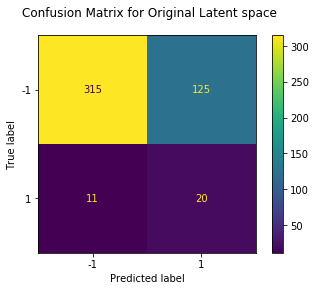

In [31]:
X_train = (Total)
y_train = (label)
X_test = (X_valmlp)
y_test = (y_valmlp)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-2.85,2.85))

X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(batch_size =250,solver='adam',hidden_layer_sizes=(9,16, 8,6,),
                    activation="tanh",learning_rate_init = 0.15,random_state=1,shuffle = True,
                    max_iter = 5000,learning_rate = 'constant',beta_1=0.9,beta_2=0.999,
                   alpha=0.009,warm_start = False)
#learning_rate_init = 0.0000595
clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for Original Latent space")
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

#### Evaluation metric

In [32]:
def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.sqrt(np.prod(tp_rate))
    return ACSA, GM

In [33]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print (acsa, gm,)

0.6805351906158358 0.6796152093976229


In [34]:
print('Time taken:',time.time()-start_time)

Time taken: 200.4611210823059


In [35]:
score_mspo = silhouette_score(Total, label, metric='l2')
print("Silhouette score for MSPO oversampled data:")
print(score_mspo)

Silhouette score for MSPO oversampled data:
0.0355620725176149
